In [44]:
import os

QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/filtered_QM9_charges_radicals_stereo.smi"
# ChEMBL_CNOF_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/filtered_ChEMBL_charges_radicals_stereo_CNOF.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"


output_fig_path = os.environ["FIGURES"] + "/07_BBO/02_models/these/HOMO/"
output_data_path = os.environ["DATA"] + "/07_BBO/02_models/these/HOMO/03.01_HOMO_prediction/"

N_JOBS = 10

dft_path = "/tmp"
os.makedirs(output_fig_path, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)

In [45]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

kernels = [
    ("RBF", 1.0*RBF(1.0)),
    ("DotProduct", 1.0*DotProduct(1.0))
]

In [46]:
import csv
from evomol.evaluation import QEDEvaluationStrategy
from evomol.evaluation_dft import OPTEvaluationStrategy
import numpy as np

def load_smiles_dataset(path):
    
    all_smiles = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            all_smiles.append(row[0])
            
    np.random.shuffle(all_smiles)
    return all_smiles
        

def compute_QED(dataset_smiles):
    
    s = QEDEvaluationStrategy()
    return [s.eval_smi(smi) for smi in dataset_smiles]

In [47]:
QM9_smiles = load_smiles_dataset(QM9_path)
# ChEMBL_smiles = load_smiles_dataset(ChEMBL_CNOF_path)

print(len(QM9_smiles))
# print(len(ChEMBL_smiles))

132040


In [48]:
import numpy as np

def gen_splits(size, n_splits):
    
    for i in range(n_splits):
        
        train_idx = np.arange(i*size, i*size + size)
        test_idx = np.array(np.setdiff1d(np.arange(n_splits*size), train_idx))
        yield train_idx, test_idx
        

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from chemdesc.descriptors import ShinglesVectDesc, MBTRDesc
from tqdm import tqdm
import time
from sklearn.model_selection import cross_validate


def procedure(complete_smiles_list, kernels, alpha_values, test_on=None):
    
    
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    eval_strat = OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                                       working_dir_path=dft_path, MM_program="rdkit")
    
    
    output_dict = {}
    
    smiles_list = complete_smiles_list[:100000]
    
#     smiles_list = complete_smiles_list[:100]
   


    X_shingles = desc_builder_shingles.fit_transform(smiles_list)[0]
    X_mbtr = desc_builder_mbtr.fit_transform(smiles_list)[0]
    y = np.array([eval_strat.eval_smi(smi) for smi in smiles_list])
    
    for kernel_tuple in kernels:
        
        if kernel_tuple[0] == "RBF":
            X = X_mbtr
        elif kernel_tuple[0] == "DotProduct":
            X = X_shingles
        else:
            print("neither")
    
        
        output_dict[kernel_tuple[0]] = {alpha: {} for alpha in alpha_values}
        
        
        for alpha_value in alpha_values:
            
            generator = gen_splits(1000, 100)
        
#             generator = gen_splits(10, 10)
        
            kernel = kernel_tuple[1]
            model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=alpha_value)

            results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", cv=generator, n_jobs=N_JOBS)
            
            output_dict[kernel_tuple[0]][alpha_value]["scores"] = list(results["test_score"])
            output_dict[kernel_tuple[0]][alpha_value]["fit_times"] = list(results["fit_time"])
            output_dict[kernel_tuple[0]][alpha_value]["score_times"] = list(results["score_time"])
        
    
            
    return output_dict



In [50]:
# results_learning = procedure(QM9_smiles, kernels, alpha_values=[1e0, 1e-1, 1e-2, 1e-3])

MM program : obabel_mmff94
None
MM program : rdkit
species MBTR  : ['C', 'H', 'O', 'N', 'F']
atomic_numbers_n : 10
inverse_distances_n : 25
cosine_angles_n : 25


 38%|███▊      | 38/100 [00:00<00:00, 378.65it/s]

DFT MM rdkit
133798 molecules in cache


100%|██████████| 100/100 [00:00<00:00, 8150.77it/s]


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
    
output_fig_path


In [52]:
import json
from os.path import join

# with open(join(output_data_path, "results.json"), "w") as f:
#     json.dump(results_learning, f)


In [53]:
import json
from os.path import join

with open(join(output_data_path, "results.json"), "r") as f:
    results_dict = json.load(f)
    

In [54]:
results_dict

{'RBF': {'1.0': {'scores': [-0.43902695828598703,
    -0.4399152438028772,
    -0.43964631837809365,
    -0.4391537024154927,
    -0.43909633002429055,
    -0.43896364721138026,
    -0.4389349932561991,
    -0.4394178911172898,
    -0.43901474817149094,
    -0.44143347228104995,
    -0.4402770884566153,
    -0.44052648705526276,
    -0.43912907062921797,
    -0.43968722162499874,
    -0.43923938087195624,
    -0.4396676493327303,
    -0.439208493445569,
    -0.4389651632734677,
    -0.4392999724120809,
    -0.4390111893185433,
    -0.4391378764447336,
    -0.43894094890090934,
    -0.44041885961609145,
    -0.44151341520411497,
    -0.44086597680746187,
    -0.43973015418840167,
    -0.4394144353231675,
    -0.439210520546599,
    -0.4395331811857773,
    -0.43923962160120134,
    -0.4388039792909877,
    -0.44164805854950073,
    -0.43922552430434175,
    -0.4400863689100189,
    -0.4420612954700835,
    -0.4414406869034342,
    -0.4402952618307086,
    -0.43907171008225904,
    -0.43

In [63]:
def plot_results(results_dict, alpha_values):
    
    for alpha_value in alpha_values:
        
        print(alpha_value)
        for kernel in ["RBF", "DotProduct"]:
            print(kernel)
            data = -np.array(results_dict[kernel][str(alpha_value)]["scores"])
            print("Moyenne : " + str(np.mean(data)))
            print("Médiane : " + str(np.median(data)))
            print("Stddev : " + str(np.std(data)))
            print("Max : " + str(np.max(data)))
        print()


In [64]:
plot_results(results_dict, [1e0, 1e-1, 1e-2, 1e-3])

1.0
RBF
Moyenne : 0.4397749037739838
Médiane : 0.43949377778323195
Stddev : 0.0008291269185872353
Max : 0.44221159059107784
DotProduct
Moyenne : 0.2736773132277595
Médiane : 0.26477565535249736
Stddev : 0.026859586389887245
Max : 0.3624015996293817

0.1
RBF
Moyenne : 0.27188055159918484
Médiane : 0.2717300018852345
Stddev : 0.0028069174877224223
Max : 0.2803241685565732
DotProduct
Moyenne : 0.2291309643900254
Médiane : 0.22889152714622557
Stddev : 0.0024956978010126896
Max : 0.23863420850478662

0.01
RBF
Moyenne : 0.286256890101414
Médiane : 0.2858030543534896
Stddev : 0.006433224137893926
Max : 0.3037095217729883
DotProduct
Moyenne : 0.23351616216162438
Médiane : 0.23294854005227703
Stddev : 0.0038162577908124927
Max : 0.24537363185146108

0.001
RBF
Moyenne : 5.414994288088134
Médiane : 5.466382961940747
Stddev : 0.5128618314327983
Max : 5.4688701090242375
DotProduct
Moyenne : 0.2377223122692913
Médiane : 0.2368292661824994
Stddev : 0.005373091021719334
Max : 0.2554809295670567



In [8]:
def show_results(results_dict, alpha_values):
   
    for alpha_value in alpha_values:
        print()
        print("alpha : " + str(alpha_value))

        print("RBF")
        print("mean : " + str(np.mean(np.absolute(results_dict["RBF"][alpha_value]['errors_list']))))
        print("med : " + str(np.median(np.absolute(results_dict["RBF"][alpha_value]['errors_list']))))
        print("max : " + str(np.max(np.absolute(results_dict["RBF"][alpha_value]['errors_list']))))

        print("DotProduct")
        print("mean : " + str(np.mean(np.absolute(results_dict["DotProduct"][alpha_value]['errors_list']))))
        print("med : " + str(np.median(np.absolute(results_dict["DotProduct"][alpha_value]['errors_list']))))
        print("max : " + str(np.max(np.absolute(results_dict["DotProduct"][alpha_value]['errors_list']))))

In [9]:
show_results(results_learning, [1e0, 1e-1, 1e-2, 1e-3])


alpha : 1.0
RBF
mean : 0.4398159549987657
med : 0.32601355857414305
max : 4.253137864894782
DotProduct
mean : 0.26800082572100337
med : 0.2116965889167175
max : 4.189415152653621

alpha : 0.1
RBF
mean : 0.27255588707257317
med : 0.20583896583237893
max : 4.231352291345644
DotProduct
mean : 0.23042127887349095
med : 0.18691817532930388
max : 3.924806489683627

alpha : 0.01
RBF
mean : 0.29053826691050627
med : 0.20802475470409165
max : 9.382517654326657
DotProduct
mean : 0.2330175096209263
med : 0.18671230403954064
max : 3.5618794823825315

alpha : 0.001
RBF
mean : 5.452381633661032
med : 6.45454408
max : 10.78387782
DotProduct
mean : 0.23793383627037967
med : 0.18862263528202794
max : 3.5093936076703844


In [50]:
np.mean(np.absolute(np.array(results_learning["DotProduct"][0.001]["errors_list"]).flatten()))

0.23793383627037967

In [52]:
np.absolute(np.array(results_learning["RBF"][0.001]["errors_list"]).flatten())

array([0.07310266, 0.98468456, 6.69128326, ..., 5.70350944, 0.10493298,
       0.13214438])

In [84]:
from os.path import join

def plot_distrib_errors(results_dict):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
    
    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        
#         for exp in [(train_QM9_test_QM9, "QM9 - QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL - ChEMBL"),
#                     (train_QM9_test_ChEMBL, "QM9 - ChEMBL"), (train_ChEMBL_test_QM9, "ChEMBL - QM9")]:
            
        for alpha_value in [0.1]:
            
            np.absolute(results_dict["RBF"][alpha_value]['errors_list'])
                
            sns.distplot(np.absolute(np.array(results_dict[t[1]][alpha_value]["errors_list"]).flatten()), 
                         ax=t[0], label="σₙ² = " + str(alpha_value), kde=False, 
                         bins=np.linspace(0, 1.5, 30))
            
            if t[1] == "RBF":
                curr_title = "GPR RBF, MBTR"
            elif t[1] == "DotProduct":
                curr_title = "GPR DotProduct, shingles"
            
            t[0].set_title(curr_title)
            t[0].set_xlabel("Erreur moyenne absolue (MAE)")
#             plt.xscale("log")
#             plt.xlim(0, 2)
#             plt.legend()
    
    plt.savefig(join(output_fig_path, "HOMO_pred_dist_mae.png"), dpi=250)
        
            

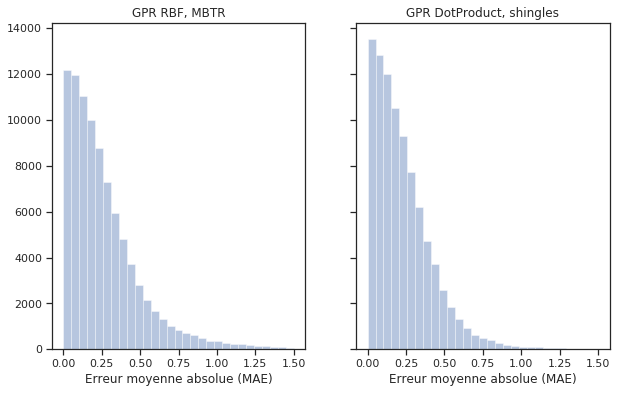

In [85]:
plot_distrib_errors(results_learning)

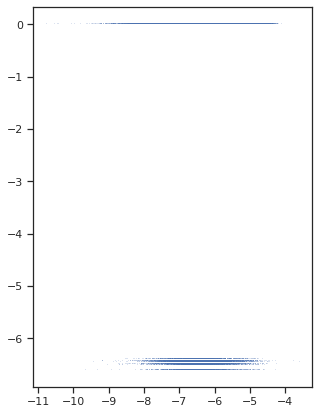

In [77]:
plt.figure(figsize=(5, 7))
plt.scatter(np.array(results_learning["RBF"][0.001]["targets_list"]).flatten(), 
            np.array(results_learning["RBF"][0.001]["errors_list"]).flatten() + np.array(results_learning["RBF"][0.001]["targets_list"]).flatten(),
            alpha=0.2, marker=',',lw=0,s=1)
# plt.plot([-10, -2], [-10, -2], color='g')

In [78]:
def errors_vs_target(data, key):
    plt.figure(figsize=(5, 7))
    plt.scatter(np.array(data[key]["targets_list"]).flatten(), 
                np.array(data[key]["errors_list"]).flatten() + np.array(data[key]["targets_list"]).flatten(),
                alpha=0.2, marker=',',lw=0,s=1)
    plt.plot([-10, -2], [-10, -2], color='g')
#     plt.xlim((0, 1))

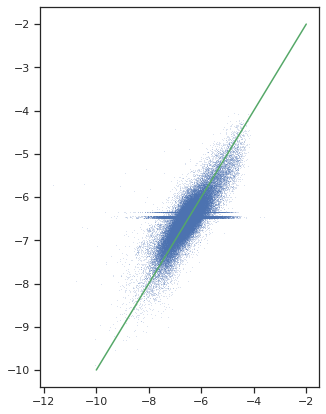

In [17]:
errors_vs_target(train_QM9_test_QM9, "RBF")

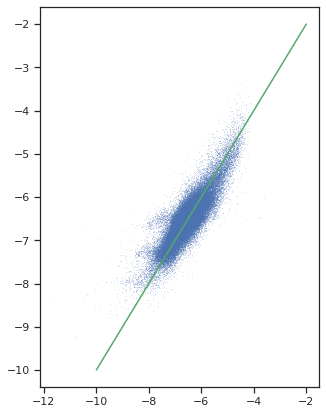

In [24]:
errors_vs_target(train_QM9_test_QM9, "DotProduct")

In [18]:
def eval_model(model, X_train, y_train, X_test, y_test, size):
    
    tstart = time.time()
    model.fit(X_train[:size], y_train[:size])
    fit_time = time.time() - tstart
    
    tstart = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - tstart
    
    MAE = np.mean(np.absolute(y_pred - y_test))
    
    return MAE, fit_time, predict_time
    

def data_efficiency_experiments(kernels, QM9_smiles):
    
    output_dict = {kernel[0]: {
        "size": [],
        "QM9_fit_time": [],
        "QM9_predict_time": [],
        "QM9_MAE": [],
    } for kernel in kernels}
    
    dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
    
    
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    eval_strat = OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                                     working_dir_path=dft_path, MM_program="rdkit")
    
    
    QM9_train_smiles, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
#     ChEMBL_train_smiles, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    QM9_train_smiles = QM9_train_smiles[:10000]
#     ChEMBL_train_smiles = ChEMBL_train_smiles[:10000]
    
    QM9_train_y = [eval_strat.eval_smi(smi) for smi in tqdm(QM9_train_smiles)]
    QM9_test_y = [eval_strat.eval_smi(smi) for smi in tqdm(QM9_test_smiles)]
#     ChEMBL_train_y = [eval_strat.eval_smi(smi) for smi in tqdm(ChEMBL_train_smiles)]
#     ChEMBL_test_y = [eval_strat.eval_smi(smi) for smi in tqdm(ChEMBL_test_smiles)]
    
    for kernel in kernels:
        print(kernel[0])
        model = GaussianProcessRegressor(kernel=kernel[1], normalize_y=False, alpha=1e-1)

        if kernel[0] == "RBF":
            desc_builder = desc_builder_mbtr
        elif kernel[0] == "DotProduct":
            desc_builder = desc_builder_shingles

        QM9_train_X = desc_builder.fit_transform(QM9_train_smiles)[0]
        QM9_test_X = desc_builder.fit_transform(QM9_test_smiles)[0]
        
        for dataset_size in dataset_sizes:
            print(dataset_size)

            
            MAE_QM9, time_fit_QM9, time_predict_QM9 = eval_model(model, QM9_train_X, QM9_train_y, 
                                                                 QM9_test_X, QM9_test_y, 
                                                                 dataset_size)

            output_dict[kernel[0]]["size"].append(dataset_size)
            output_dict[kernel[0]]["QM9_fit_time"].append(time_fit_QM9)
            output_dict[kernel[0]]["QM9_predict_time"].append(time_predict_QM9)
            output_dict[kernel[0]]["QM9_MAE"].append(MAE_QM9)

            
    return output_dict
            

In [19]:
output_data_efficiency = data_efficiency_experiments(kernels, QM9_smiles)

MM program : obabel_mmff94
None
MM program : rdkit
species MBTR  : ['C', 'H', 'O', 'N', 'F']
atomic_numbers_n : 10
inverse_distances_n : 25
cosine_angles_n : 25


  4%|▍         | 388/10000 [00:00<00:02, 3871.30it/s]

DFT MM rdkit
133798 molecules in cache


  0%|          | 0/10000 [00:00<?, ?it/s]

RBF


100%|██████████| 50000/50000 [08:45<00:00, 95.06it/s] 


10
30
100
300
1000
3000
10000


  0%|          | 21/10000 [00:00<00:48, 206.57it/s]

DotProduct


100%|██████████| 50000/50000 [02:07<00:00, 391.58it/s]


10
30
100
300
1000
3000
10000


In [22]:
def time_desc(QM9_smiles):
        
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=1, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    _, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    
    tstart = time.time()
    desc_builder_mbtr.fit_transform(QM9_test_smiles)
    time_mbtr_desc = time.time() - tstart
    
    tstart = time.time()
    desc_builder_shingles.fit_transform(QM9_test_smiles)
    time_shingles_desc = time.time() - tstart
    
    return time_mbtr_desc, time_shingles_desc

In [23]:
time_mbtr_desc, time_shingles_desc= time_desc(QM9_smiles)

  0%|          | 0/50000 [00:00<?, ?it/s]

MM program : obabel_mmff94
None
MM program : rdkit
species MBTR  : ['C', 'H', 'O', 'N', 'F']
atomic_numbers_n : 10
inverse_distances_n : 25
cosine_angles_n : 25


100%|██████████| 50000/50000 [02:12<00:00, 376.68it/s]


In [25]:
time_mbtr_desc/50

82.09350363731384

In [26]:
time_shingles_desc/50

2.655337414741516

In [79]:
import numpy as np
import pandas as pd
from os.path import join



def plot_data_efficiency(output_data_efficiency, time_mbtr_desc, time_shingles_desc):
    
    d = {"size": [], "Données": [], "predict_time": [], "desc_predict_time": [], "fit_time": [], "MAE": [], 
         "Modèle GPR": []} 
    
    k = "RBF"
    
    predict_time_denominateur = 50
    
    for k in ["RBF", "DotProduct"]:
        
        if k == "RBF":
            curr_time_desc = time_mbtr_desc
            name = "RBF, MBTR"
        elif k == "DotProduct":
            curr_time_desc = time_shingles_desc
            name = "DotProduct, shingles"
        
        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "QM9"))
        d["Modèle GPR"].extend(np.full(len(output_data_efficiency[k]["size"],), name))
        d["fit_time"].extend(output_data_efficiency[k]["QM9_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur + curr_time_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["QM9_MAE"])

        
    df = pd.DataFrame.from_dict(d)

   
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x="size", y="MAE", hue="Modèle GPR", legend="brief")
    plt.ylabel("Erreur moyenne absolue (MAE)")
    plt.xlabel("Taille des données d'entraînement")
    plt.ylim(0, 0.5)
    
    plt.savefig(join(output_fig_path, "HOMO_MAE.png"), dpi=250)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True) #sharey=True)

    
#     handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(handles=handles[:2], labels=labels, title="Whatever else")
#     ax1.legend(handles=handles[2:4], labels=labels, title="Whatever else")
    

    sns.lineplot(x="size", y="fit_time", hue="Modèle GPR", data=df[df["Données"] == "QM9"], ax=ax1, legend=False)
    sns.lineplot(x="size", y="predict_time", hue="Modèle GPR", data=df[df["Données"] == "QM9"], ax=ax2, legend=False)
    sns.lineplot(x="size", y="desc_predict_time", hue="Modèle GPR", data=df, ax=ax3)
    
    ax1.set_xlabel("Taille des données d'entraînement")
    ax1.set_ylabel("Temps (s)")
    ax1.set_yscale("log")
    ax1.set_ylim(1e-3, 1e4)
    ax1.set_title("Entraînement")
    
    ax2.set_xlabel("Taille des données d'entraînement")
    ax2.set_ylabel("")
    ax2.set_yscale("log")
    ax2.set_ylim(1e-3, 1e4)
    ax2.set_title("Prédiction (1000 mol.)")
    
    ax3.set_xlabel("Taille des données d'entraînement")
    ax3.set_ylabel("")
    ax3.set_yscale("log")
    ax3.set_ylim(1e-3, 1e4)
    ax3.set_title("Descripteurs + prédiction (1000 mol.)")
    ax3.legend(loc="lower right")
    
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(join(output_fig_path, "HOMO_times.png"), dpi=250)
    
    return df

size Données  predict_time  desc_predict_time     fit_time       MAE  \
0      10     QM9      0.015472          82.108976     0.095865  0.453250   
1      30     QM9      0.038546          82.132049     0.036744  0.437374   
2     100     QM9      0.118298          82.211801     0.144309  0.437665   
3     300     QM9      0.365448          82.458952     0.994808  0.300310   
4    1000     QM9      1.395566          83.489070    10.041737  0.271425   
5    3000     QM9      4.214838          86.308341   103.271870  0.248424   
6   10000     QM9     13.991101          96.084605  1162.460832  0.226216   
7      10     QM9      0.002711           2.658049     0.011069  0.411631   
8      30     QM9      0.003556           2.658894     0.021632  0.401060   
9     100     QM9      0.005723           2.661060     0.055290  0.302581   
10    300     QM9      0.009432           2.664769     0.131183  0.248976   
11   1000     QM9      0.024207           2.679545     1.417535  0.227468   
12   3000     QM9      0.066245           2.721582    11.429085  0.218584   
13  10000     QM9      0.301359           2.956697   235.010689  0.212537   

              Modèle GPR  
0              RBF, MBTR  
1              RBF, MBTR  
2              RBF, MBTR  
3              RBF, MBTR  
4              RBF, MBTR  
5              RBF, MBTR  
6              RBF, MBTR  
7   DotProduct, shingles  
8   DotProduct, shingles  
9   DotProduct, shingles  
10  DotProduct, shingles  
11  DotProduct, shingles  
12  DotProduct, shingles  
13  DotProduct, shingles

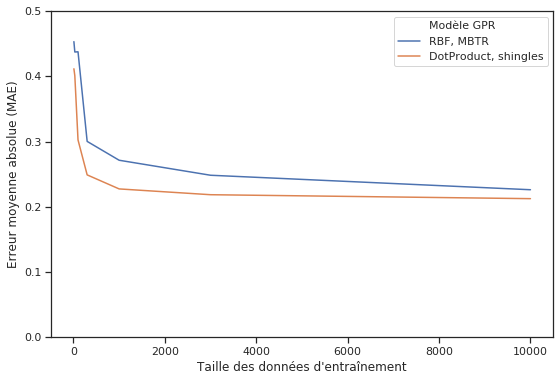

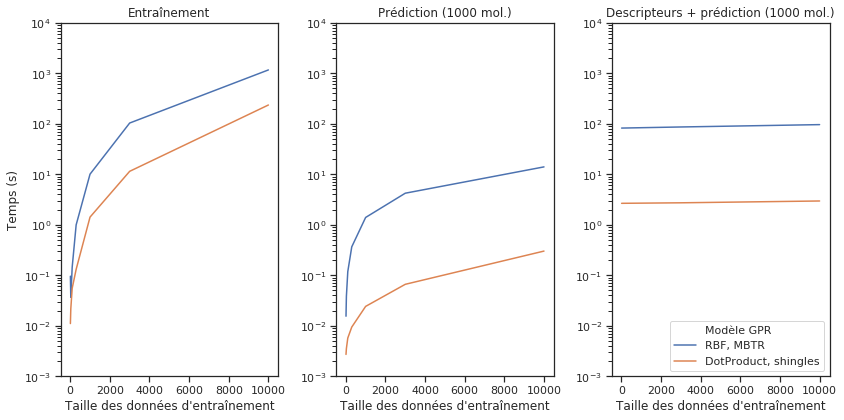

In [80]:
plot_data_efficiency(output_data_efficiency, time_mbtr_desc, time_shingles_desc)

In [81]:
output_data_efficiency

{'RBF': {'size': [10, 30, 100, 300, 1000, 3000, 10000],
  'QM9_fit_time': [0.09586453437805176,
   0.0367436408996582,
   0.14430880546569824,
   0.9948077201843262,
   10.041736602783203,
   103.27187013626099,
   1162.460832118988],
  'QM9_predict_time': [0.7736244201660156,
   1.9272782802581787,
   5.914877414703369,
   18.27240777015686,
   69.77832365036011,
   210.74188423156738,
   699.5550472736359],
  'QM9_MAE': [0.45324956147634365,
   0.43737354619104146,
   0.4376647577946008,
   0.30030959815958186,
   0.2714248989246445,
   0.24842361601218854,
   0.22621561241750762]},
 'DotProduct': {'size': [10, 30, 100, 300, 1000, 3000, 10000],
  'QM9_fit_time': [0.01106882095336914,
   0.021631956100463867,
   0.05528998374938965,
   0.13118290901184082,
   1.4175353050231934,
   11.429084539413452,
   235.01068902015686],
  'QM9_predict_time': [0.13556671142578125,
   0.1778106689453125,
   0.28615236282348633,
   0.47157955169677734,
   1.210357904434204,
   3.3122518062591553,
  